## Setup

Set the project to match the DeepLearning project I have on the Google Cloud Platform

In [0]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'deeplearning-241314'
!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



## Fetch data

Get the data from the shared Drive folder we have

**This should be improved** by storing the file somewhere smarter.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

     |████████████████████████████████| 993kB 2.0MB/s 
Downloaded content with length "669380879"


In [0]:
# try to load the json data
import json

jsonObject = json.loads(downloaded.GetContentString())

In [0]:
print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. Similar processes\nat charm, bottom, and top

## Parse the JSON

In [0]:
all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())
#n_letters = 257 # the first 256 ASCII characters + a "bin" for weird characters

In [0]:
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))

Physics : 206635
Computer Science : 143555
Economics : 672
Electrical Engineering and Systems Science : 6325
Mathematics : 156471
Quantitative Biology : 25791
Quantitative Finance : 11826
Statistics : 22096


## Reduce data set

In [0]:
# use only mathematics, physics and CS
all_categories = ["Mathematics", "Physics", "Computer Science"]
for key in list(articles_dict.keys()):
    if key not in all_categories:
        del articles_dict[key]
        
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    
all_categories.append("fake")
n_categories = len(all_categories)

Mathematics : 156471
Physics : 206635
Computer Science : 143555


## Turn abstracts into tensors

In [0]:
import torch
import string
import unicodedata

n_letters = len(string.printable)+1

def lineToTensor(text):
    tensor = torch.zeros(len(text), 1, n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[idx, 0, pos] = 1
    return tensor

print(lineToTensor("Ro"))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


## Create the architecture

In [0]:
import torch.nn as nn

n_hidden = n_letters

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.lstm_layer = nn.LSTM(input_size, hidden_size, 1)
        
        
        self.lstm_to_classification = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        hidden , (h_t, c_t) = self.lstm_layer(input)
        output = self.lstm_to_classification(hidden[-1])
        return output
rnn=LSTM(n_letters, n_hidden, n_categories)

In [0]:
inp = lineToTensor("Rodrigo is my name")
output = rnn(inp)
print(output)

tensor([[ 0.0614, -0.1212,  0.0698, -0.1107]], grad_fn=<AddmmBackward>)


## Prepare for training

In [0]:
def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(rnn(lineToTensor("some random line here"))))

('Computer Science', 2)


In [0]:
from random import choice, choices
import torch
import string

def randomTrainingExample(use_first_n_characters):
    category = choice(all_categories)
    if category != "fake":
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        article = choice(articles_dict[category])
        abstract = article["abstract"][:use_first_n_characters]
        abstract_tensor = lineToTensor(abstract)
        return category, abstract, category_tensor, abstract_tensor
    else:
        category_tensor = torch.tensor([len(all_categories)-1], dtype=torch.long)
        abstract = "".join(choices(string.printable, k=use_first_n_characters))
        abstract_tensor = lineToTensor(abstract)
        return category, abstract, category_tensor, abstract_tensor

randomTrainingExample(100)

('fake',
 '+c\tE\x0cu1fWp\'x.9,)oG2-,9`fm$\rJXYb<q\x0c7\x0bv{.%}(fvgr9wk\r{BgSLC9)mPZkP7W1JF:U_;vw %v"-x^\rRKLn(qOOu8z,-gQ6\r~',
 tensor([3]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.]]]))

## Train the network

In [0]:
import time
import torch.optim as optim

learning_rate = 0.001


skipped = 0
rnn=LSTM(n_letters, n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 15000
batch_size = 6
use_first_characters = 50
print_every = 100
plot_every = 10

# keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters)
    category_batch = torch.zeros(batch_size, dtype=torch.long)
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            skipped += 1
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
print("Skipped a total of {} (maybe non-unique) articles".format(skipped))

100 0.67% (0.0m 3.4212467670440674s) 1.364 / Physics V
200 1.33% (0.0m 6.899254083633423s) 1.385 / Physics X fake
300 2.0% (0.0m 10.267653226852417s) 1.359 / Physics X Computer Science
400 2.67% (0.0m 13.535160779953003s) 1.393 / Physics X Computer Science
500 3.33% (0.0m 16.781131267547607s) 1.395 / Physics X Computer Science
600 4.0% (0.0m 20.098289489746094s) 1.371 / fake V
700 4.67% (0.0m 23.563456535339355s) 1.378 / fake V
800 5.33% (0.0m 27.005763292312622s) 1.382 / fake X Computer Science
900 6.0% (0.0m 30.40406823158264s) 1.391 / Computer Science V
1000 6.67% (0.0m 33.71781539916992s) 1.38 / Physics V
1100 7.33% (0.0m 36.97696042060852s) 1.368 / fake V
1200 8.0% (0.0m 40.30949282646179s) 1.391 / fake X Mathematics
1300 8.67% (0.0m 43.56100296974182s) 1.357 / fake X Computer Science
1400 9.33% (0.0m 46.834632396698s) 1.382 / fake V
1500 10.0% (0.0m 50.13125538825989s) 1.368 / fake X Computer Science
1600 10.67% (0.0m 53.414668798446655s) 1.375 / Computer Science V
1700 11.33% (0

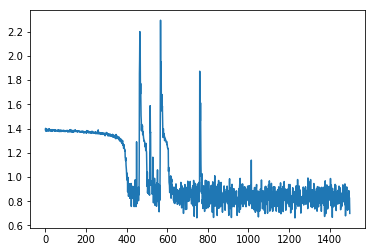

In [0]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)